In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取数据文件
orders = pd.read_csv('data/instacart/orders.csv')
order_products = pd.read_csv('data/instacart/order_products__prior.csv')
products = pd.read_csv('data/instacart/products.csv')
aisles = pd.read_csv('data/instacart/aisles.csv')

# 数据合并
# 先合并订单和订单产品
df = pd.merge(orders, order_products, on='order_id', how='inner')

# 再合并产品信息
df = pd.merge(df, products, on='product_id', how='inner')

# 最后合并货架信息
df = pd.merge(df, aisles, on='aisle_id', how='inner')

# 显示合并后的数据前几行
print("合并后的数据预览：")


# 显示数据基本信息
print("\n数据基本信息：")
print(df.info())
df.head()

合并后的数据预览：

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
dtypes: float64(1), int64(10), object(3)
memory usage: 3.4+ GB
None


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods


In [2]:
df.isnull().sum()/df.shape[0]  #数据缺失率，没有缺失值

order_id                  0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    0.06407
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
dtype: float64

In [5]:
# 创建用户和货架类别的交叉表
# 首先计算每个用户对每个货架的购买次数
user_aisle = df.groupby(['user_id', 'aisle_id']).size().reset_index(name='count')

# 将数据透视为交叉表格式
user_aisle_pivot = user_aisle.pivot_table(
    index='user_id',
    columns='aisle_id',
    values='count',
    fill_value=0
)

# 显示交叉表的形状和前几行
print(f"交叉表形状: {user_aisle_pivot.shape}")
print("\n交叉表前5行:")
user_aisle_pivot.head() #数据比较稀疏


交叉表形状: (206209, 134)

交叉表前5行:


aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
del df

In [7]:
# 使用PCA对用户-货架交叉表进行降维
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# 应用PCA降维
pca = PCA(n_components=0.9) 
user_aisle_pca = pca.fit_transform(user_aisle_pivot)

print(f"PCA降维后的形状: {user_aisle_pca.shape}")
print(f"保留的方差比例: {pca.explained_variance_ratio_.sum():.4f}")
print(f"保留的特征数量: {pca.n_components_}")


PCA降维后的形状: (206209, 27)
保留的方差比例: 0.9015
保留的特征数量: 27


KeyboardInterrupt: 

K=3时的轮廓系数: 0.5489


TypeError: float() argument must be a string or a real number, not 'KMeans'

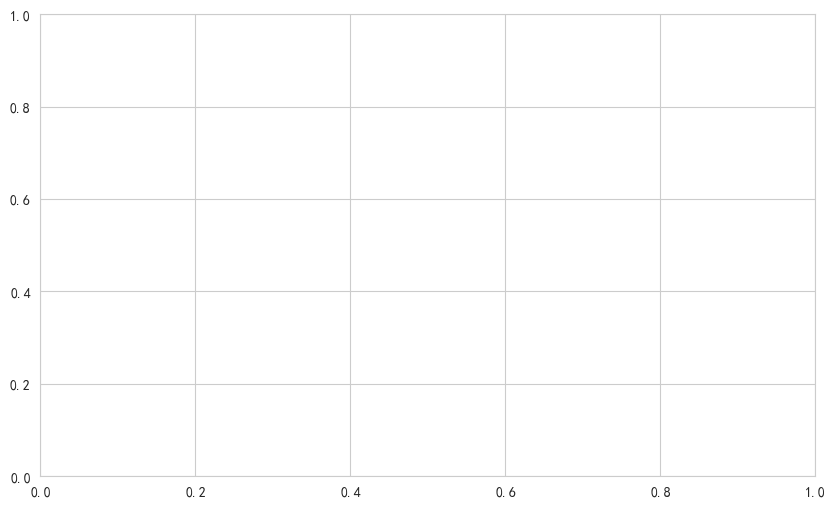

In [9]:
# 使用K-means聚类，分为3类
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(user_aisle_pca)
predict = kmeans.predict(user_aisle_pca)
# 计算轮廓系数进行评估
silhouette_avg = silhouette_score(user_aisle_pca, predict)
print(f"K=3时的轮廓系数: {silhouette_avg:.4f}")



In [16]:
colored = ['orange', 'green', 'blue']
colr = [colored[i] for i in predict]

In [14]:
np.unique(predict)

array([0, 1, 2])

C:\Users\41507\AppData\Local\Temp\ipykernel_16340\1715224611.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=colr, cmap='viridis', alpha=0.5)


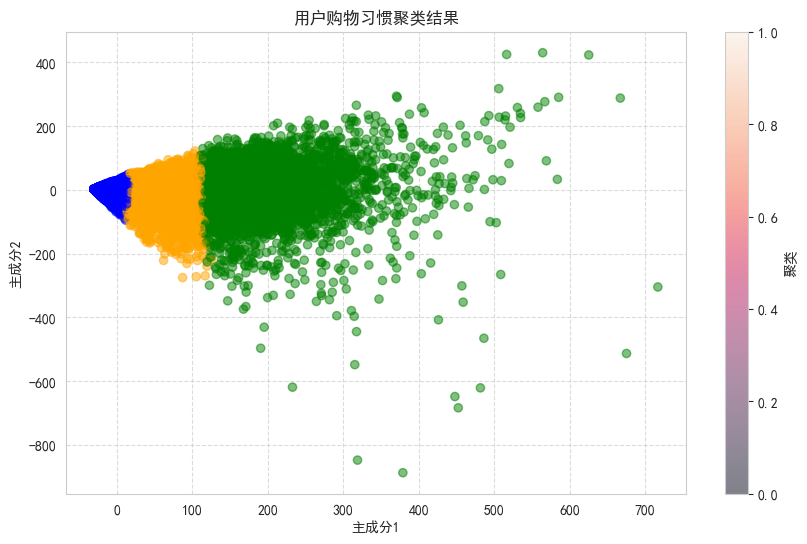

In [17]:
# 可视化聚类结果（取前两个主成分）
plt.figure(figsize=(10, 6))
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=colr, cmap='viridis', alpha=0.5)
plt.title("用户购物习惯聚类结果")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.colorbar(label='聚类')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
